# Using matrix-based kernels

We demonstrate how to work with custom kernels with `cygrid`. In most use cases this won't be necessary, as the most important kernel shapes are already built-in. Since the kernel functions have to be defined in the Cython-part of the code (for speed), it is unfortunately not possible to use Python-domain functions. To make it possible at all, custom kernels have to be defined via a kernel matrix, a 2D array, which is then applied locally to a tangential projection of the coordinates associated with the input samples. This of course means, that it will only work for small kernels and/or maps with little curvature of the graticules.

We start by adjusting the notebook settings.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as pl

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.utils import NumpyRNGContext

import cygrid

For our first demonstration, we sample random data and add some point sources.

In [3]:
def setup_data(mapcenter, mapsize, beamsize_fwhm, num_samples, num_sources):
    '''
    Produce test data (including coords) - containing just noise and some point sources.
    
    Note: as in real astronomical measurements, the point sources are convolved with the
          instrument's response function (PSF), or telescope beam.
    '''

    lon_scale = np.cos(np.radians(mapcenter[1]))
    map_l, map_r = (
        mapcenter[0] - 1.1 * mapsize[0] / 2. / lon_scale,
        mapcenter[0] + 1.1 * mapsize[0] / 2. / lon_scale
        )
    map_b, map_t = mapcenter[1] - 1.1 * mapsize[1] / 2., mapcenter[1] + 1.1 * mapsize[1] / 2.
    
    # coordinates are drawn from a uniform distribution
    xcoords = np.random.uniform(map_l, map_r, num_samples).astype(np.float64)
    ycoords = np.random.uniform(map_b, map_t, num_samples).astype(np.float64)

    # add Gaussian noise
    signal = np.random.normal(0., 0.01, len(xcoords))
    
    beamsize_sigma = beamsize_fwhm / np.sqrt(8 * np.log(2))
    
    # put in artifical point source, with random amplitudes
    # we'll assume a Gaussian-shaped PSF
    
    def gauss2d(x, y, x0, y0, A, s):
        return A * np.exp(-((x-x0)**2 + (y-y0)**2) / 2. / s**2)
    
    for _ in range(num_sources):
        
        sou_x = np.random.uniform(map_l, map_r, 1).astype(np.float64)
        sou_y = np.random.uniform(map_b, map_t, 1).astype(np.float64)
        A = np.random.uniform(0, 10, 1)
        signal += gauss2d(xcoords, ycoords, sou_x, sou_y, A, beamsize_sigma)

    signal = signal[:, np.newaxis]  # need dummy spectral axis
    return xcoords, ycoords, signal

In [4]:
mapcenter = 60., 30.  # all in degrees
mapsize = 5., 5.
beamsize_fwhm = 0.01
num_samples = 10 ** 6
num_sources = 20

with NumpyRNGContext(1):
    xcoords, ycoords, signal = setup_data(
        mapcenter, mapsize, beamsize_fwhm, num_samples, num_sources
        )

 Now define a FITS header dictionary, which we can feed to the gridder.

In [5]:
def setup_header(mapcenter, mapsize, beamsize_fwhm):
    '''
    Produce a FITS header that contains the target field.
    '''
    
    # define target grid (via fits header according to WCS convention)
    # a good pixel size is a third of the FWHM of the PSF (avoids aliasing)
#     pixsize = beamsize_fwhm / 3.
    pixsize = beamsize_fwhm / 0.5  # hefty undersampling
    dnaxis1 = int(mapsize[0] / pixsize)
    dnaxis2 = int(mapsize[1] / pixsize)

    header = {
        'NAXIS': 3,
        'NAXIS1': dnaxis1,
        'NAXIS2': dnaxis2,
        'NAXIS3': 1,  # need dummy spectral axis
        'CTYPE1': 'RA---SIN',
        'CTYPE2': 'DEC--SIN',
        'CUNIT1': 'deg',
        'CUNIT2': 'deg',
        'CDELT1': -pixsize,
        'CDELT2': pixsize,
        'CRPIX1': dnaxis1 / 2.,
        'CRPIX2': dnaxis2 / 2.,
        'CRVAL1': mapcenter[0],
        'CRVAL2': mapcenter[1],
        }
    
    return header
    
    
    

In [6]:
target_header = setup_header(mapcenter, mapsize, beamsize_fwhm)

# let's already define a WCS object for later use in our plots:
target_wcs = WCS(target_header)

Now define a matrix with a funky log-spiral kernel.

In [7]:
kernelsize_fwhm = beamsize_fwhm / 2.
kernelsize_sigma = kernelsize_fwhm / np.sqrt(8 * np.log(2))
support_radius = 50. * kernelsize_sigma

In [8]:
dx, dy = abs(target_header['CDELT1']) / 5., abs(target_header['CDELT2'] / 5.)
print('dx, dy', dx, dy)

# make kernel size odd (for each dimension)
nx = 2 * int(support_radius / dx + 0.5) + 1
ny = 2 * int(support_radius / dy + 0.5) + 1
print('nx, ny', nx, ny)

# put ref pixel exactly in the middle
refpix_x, refpix_y = nx // 2, ny // 2
print('refpix_x, refpix_y', refpix_x, refpix_y)

xvec = (np.arange(nx) - refpix_x) * dx
yvec = (np.arange(ny) - refpix_y) * dy

# print(xcoords, ycoords)

dx, dy 0.004 0.004
nx, ny 55 55
refpix_x, refpix_y 27 27


In [17]:
def gauss_1d(x, y, x0, y0, sigma):
    
    r2 = (x - x0) ** 2 + (y - y0) ** 2
    return np.exp(-r2 / 2. / sigma ** 2)

# log spiral kernel:
gauss_matrix_kernel = np.zeros((nx, ny))
a, b, c = 0.004, 1. / 3., 3.4
theta = np.linspace(np.pi / 4., c * 2 * np.pi, 1000)
r = a * np.exp(b * theta)
x0 = r * np.cos(theta)
y0 = r * np.sin(theta)
for _x, _y, _t, _r in zip(x0, y0, theta, r):
    gauss_matrix_kernel += gauss_1d(
        xvec[np.newaxis, :], yvec[:, np.newaxis], 
        _x, _y,
        4 * kernelsize_sigma,
        ) * _r ** 1.2

# It is more fun, if we have two spiral arms ;-)
gauss_matrix_kernel = gauss_matrix_kernel + gauss_matrix_kernel[::-1, ::-1]
    
# Note, it is not necessary, to normalize the kernel, as the 
# cygrid gridding algorithm will take care of it
# gauss_matrix_kernel /= np.nansum(gauss_matrix_kernel)

In [18]:
imkw = dict(
    cmap='viridis_r',
    origin='lower',
    interpolation='nearest')

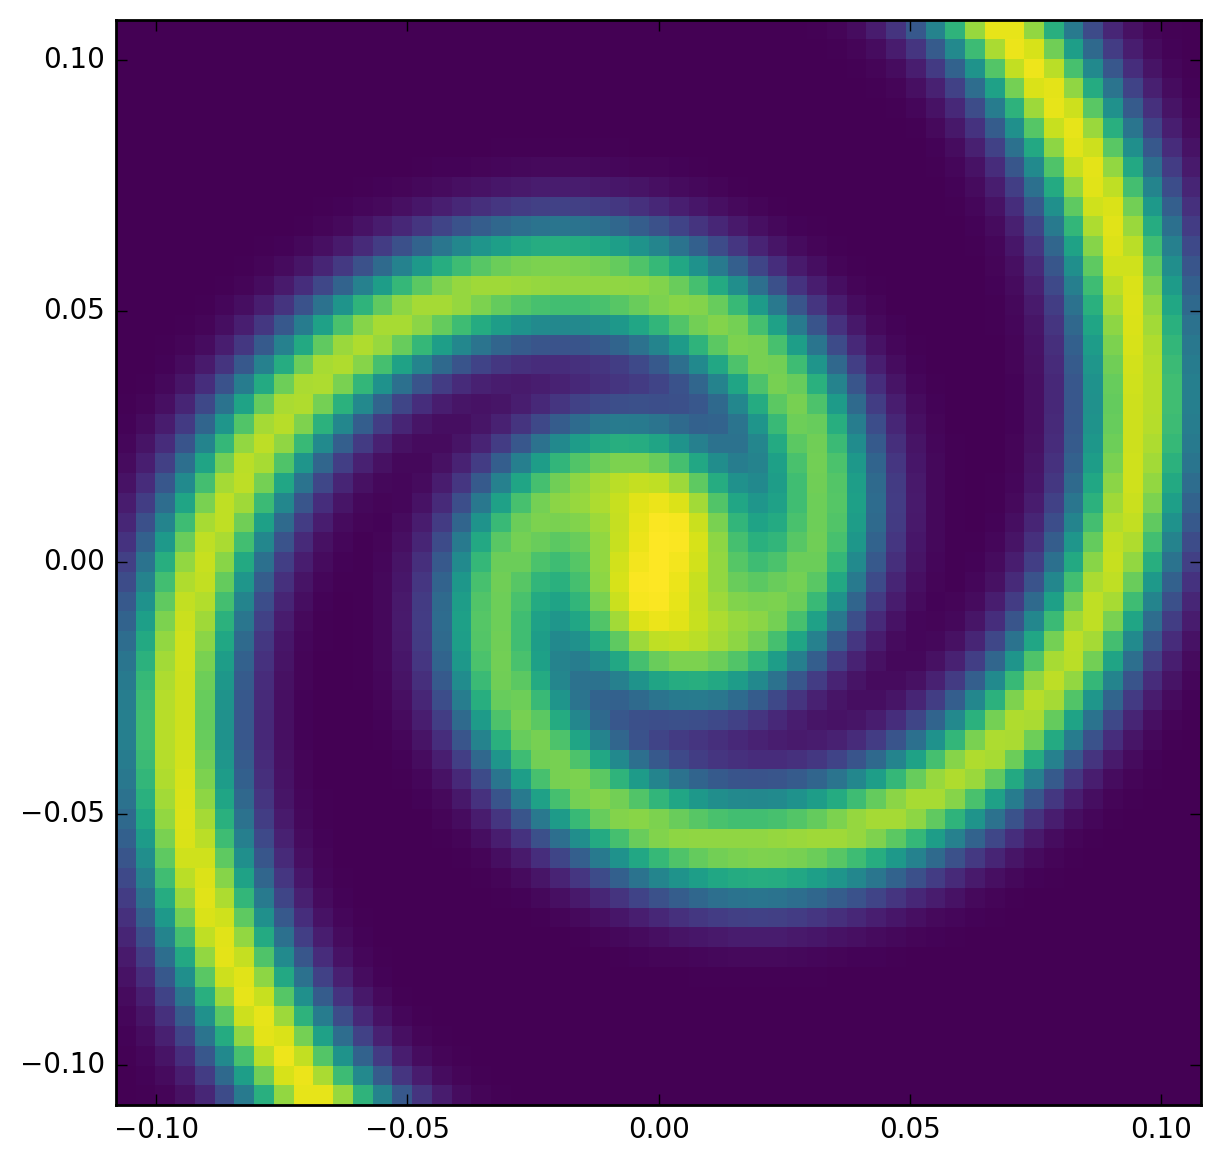

In [19]:
fig = pl.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.imshow(
    gauss_matrix_kernel, 
    extent=(xvec[0], xvec[-1], yvec[0], yvec[-1]), 
    origin='lower', cmap='viridis', interpolation='nearest',
    )
ax.set_aspect('equal')
pl.show()

In [20]:
gridder = cygrid.WcsGrid(target_header)

In [21]:
gridder.set_kernel(
    'matrix2d',
    (gauss_matrix_kernel, (refpix_x, refpix_y), (dx, dy)),
    np.sqrt(2.) * support_radius,
    kernelsize_sigma * 2.
    )

After the kernel has been set, we perform the actual gridding by calling `grid()` with the flattened coordinates and the data. Note that we need to add an artifical third axis to the `input_data`. This will take a while, as the kernel is really large.

In [22]:
gridder.grid(xcoords, ycoords, signal)

In [23]:
cygrid_map = gridder.get_datacube().squeeze()

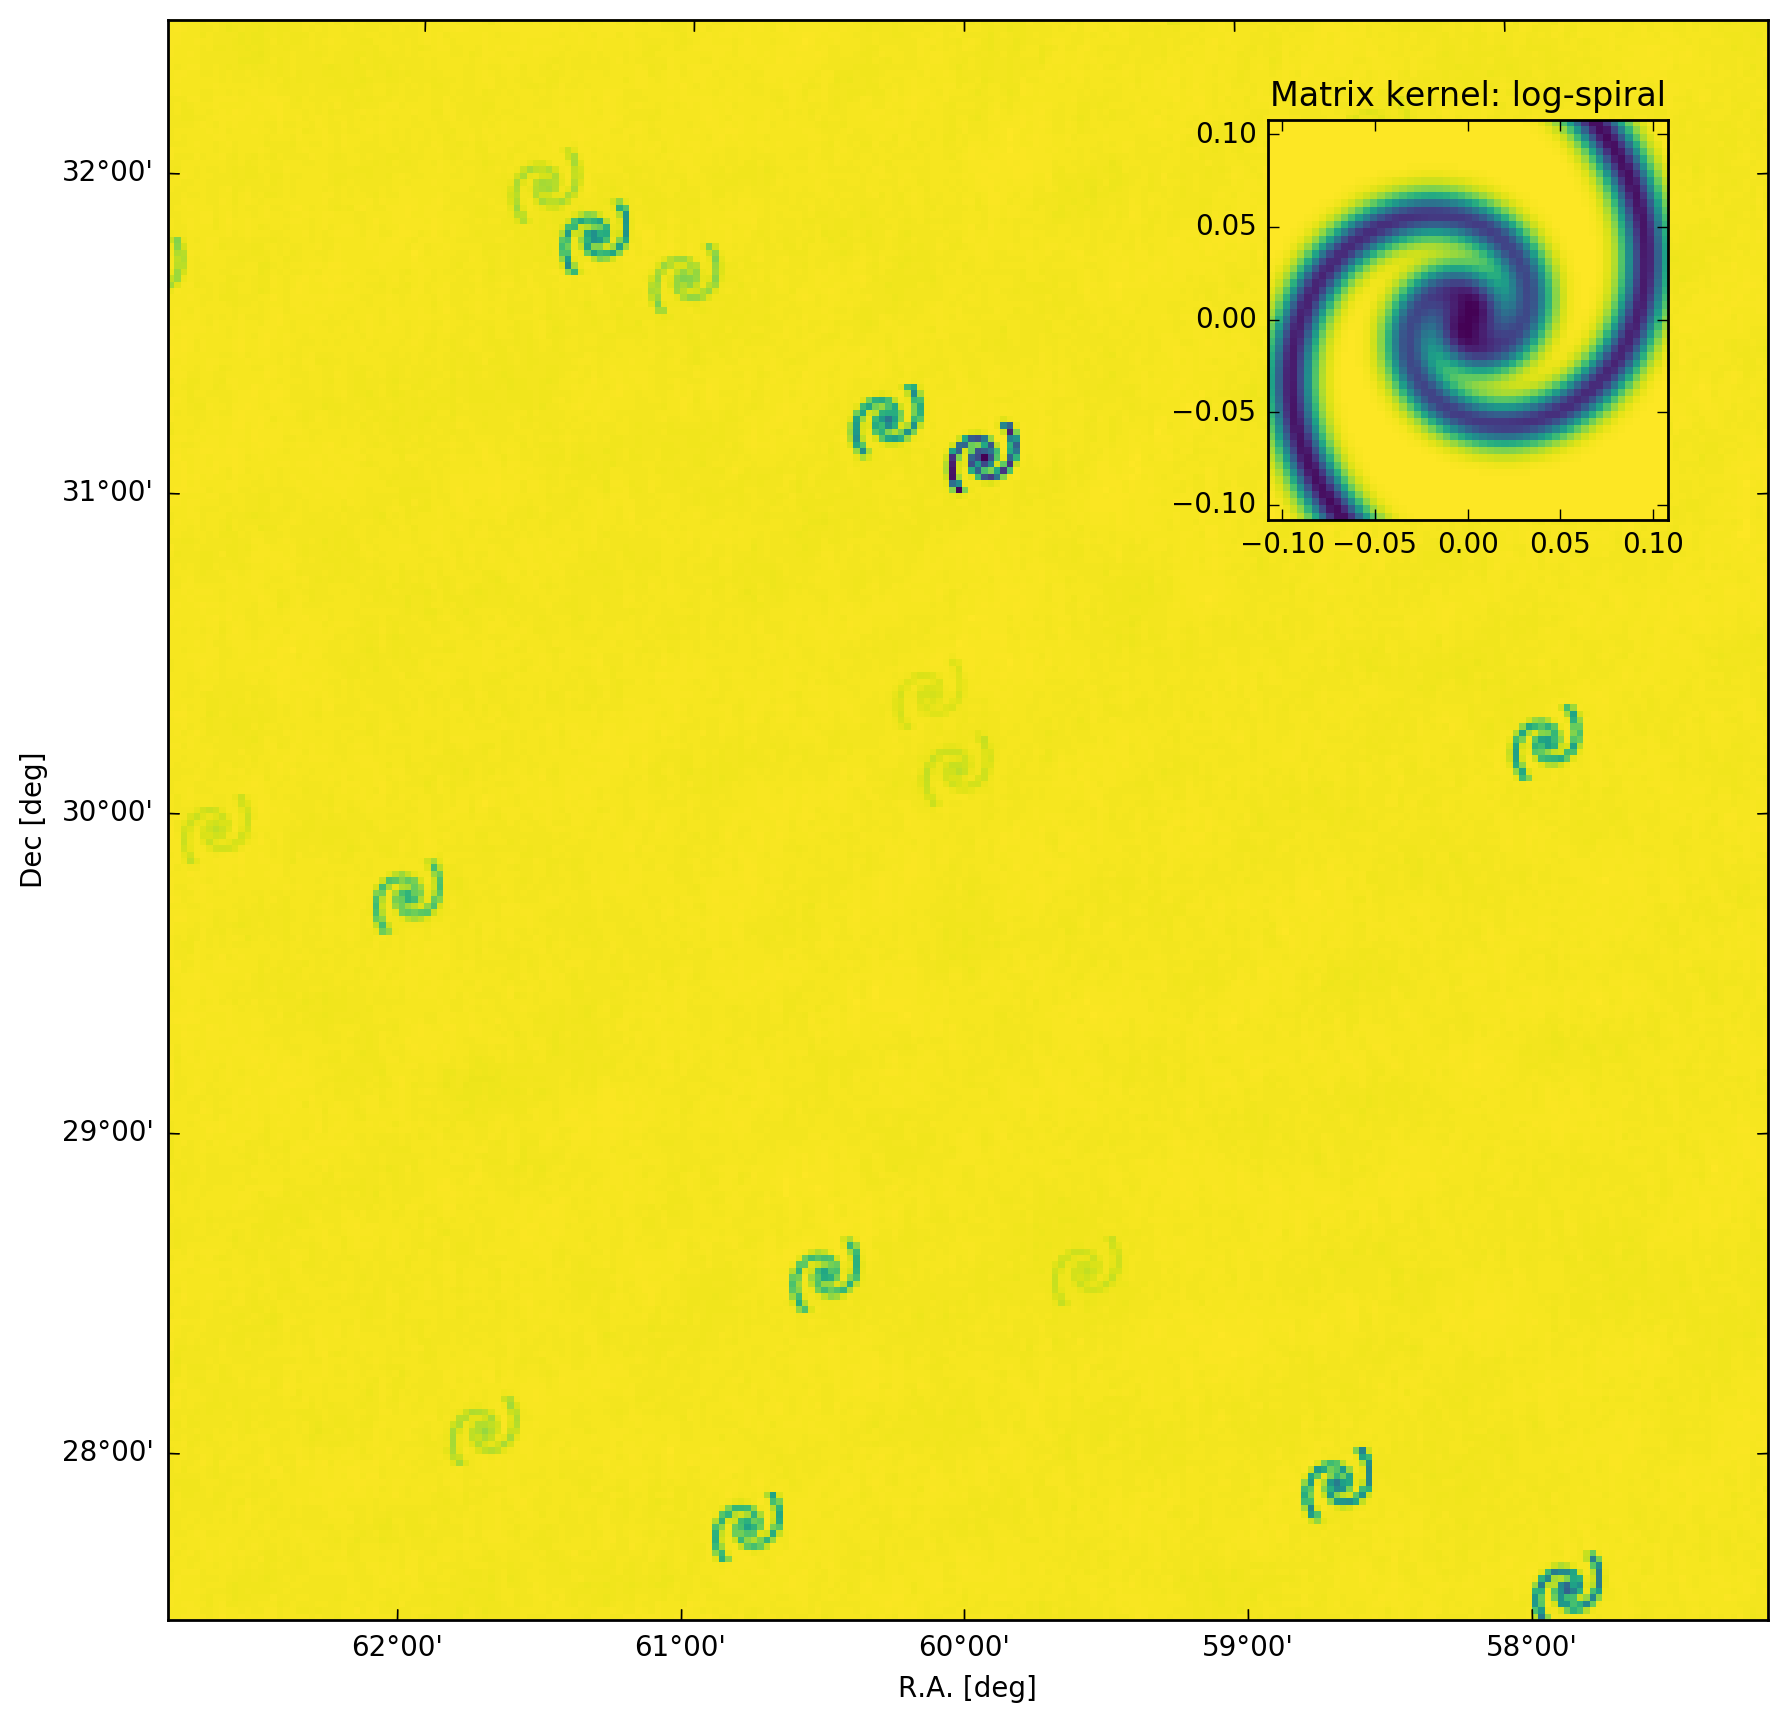

In [24]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8), projection=target_wcs.celestial)
zax = fig.add_axes((0.65, 0.65, 0.2, 0.2))
ax.imshow(cygrid_map, **imkw)  # , vmin=-0.25, vmax=2.0
zax.imshow(
    gauss_matrix_kernel, 
    extent=(xvec[0], xvec[-1], yvec[0], yvec[-1]), 
    **imkw,
    )
zax.set_aspect('equal')
zax.set_title('Matrix kernel: log-spiral')
lon, lat = ax.coords
lon.set_axislabel('R.A. [deg]')
lat.set_axislabel('Dec [deg]')
pl.show()